# Midterm Assignment

* Model A: Train a binary classifier using transfer learning
    * Images downscled to 128x128
* Create GAN model
    * Train SRGAN to generate 128x128 images.
    * Downscale images to 32x32

We use the cat vs. dog dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import os

from sklearn.metrics import confusion_matrix,classification_report

import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, Convolution2D, MaxPool2D, Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.losses import BinaryCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16, ResNet50
from keras import applications

from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping


2023-11-06 07:06:24.441000: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_dataset_path = 'small-training/train/'
val_dataset_path = 'small-training/validation/'
test_dataset_path = 'small-training/test/'

In [ ]:
BATCH_SIZE = 34
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

print(f"Batch Size: {BATCH_SIZE}")
print(f"Image Shape: {IMG_SHAPE}")

Batch Size: 34
Image Shape: (128, 128, 3)


In [3]:
fold_num = 2
df_train = pd.read_csv('small-training/df_train.csv')
df_train.sample(frac = 1, random_state = fold_num)


#df_val = pd.read_csv(val_dataset_path )
#df_val.sample(frac = 1, random_state = fold_num)

Class       Filename
721     dog   dog.4328.jpg
4876    cat   cat.9073.jpg
3088    dog   dog.4227.jpg
14190   cat   cat.4582.jpg
6994    dog    dog.835.jpg
...     ...            ...
1099    cat  cat.12346.jpg
18898   cat   cat.9627.jpg
11798   dog   dog.8203.jpg
6637    cat   cat.7789.jpg
2575    dog   dog.9364.jpg

[20081 rows x 2 columns]

In [4]:

df_test = pd.read_csv('small-training/df_test.csv')
df_test.sample(frac = 1, random_state = fold_num)

Class       Filename
1310   cat  cat.10489.jpg
2461   dog   dog.7241.jpg
1580   cat   cat.7591.jpg
1938   dog  dog.10252.jpg
1124   dog   dog.2146.jpg
...    ...            ...
674    dog   dog.3890.jpg
2408   cat     cat.76.jpg
1099   cat   cat.6986.jpg
2347   dog   dog.5380.jpg
1608   cat   cat.6858.jpg

[2500 rows x 2 columns]

In [5]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range = 0.2,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  vertical_flip = True,
                                  fill_mode = 'nearest',
                                  validation_split = 0.1)

train_generator = train_datagen.flow_from_dataframe(dataframe = df_train,
                                                directory = DirPath + 'Assignment-1/Datasets2/train/',
                                                target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                batch_size = BATCH_SIZE,
                                                class_mode = 'binary',
                                                x_col = 'Filename',
                                                y_col = 'Class',
                                                color_mode = 'rgb',
                                                shuffle = True)


NameError: name 'DirPath' is not defined

In [ ]:
validation_generator = train_datagen.flow_from_dataframe(dataframe = df_val,
                                                directory = DirPath + 'Assignment-1/Datasets2/validation/',
                                                target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                batch_size = BATCH_SIZE,
                                                class_mode = 'binary',
                                                x_col = 'Filename',
                                                y_col = 'Class',
                                                color_mode = 'rgb',
                                                shuffle = True)

Found 2500 validated image filenames belonging to 2 classes.


In [ ]:
test_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip = True,
    vertical_flip = True,
    zoom_range = 0.2,
    rotation_range = 90,
    fill_mode = 'constant')

test_generator = test_datagen.flow_from_dataframe(dataframe = df_test,
                                                  directory = DirPath + 'Assignment-1/Datasets2/test/',
                                                  target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                  batch_size = BATCH_SIZE,
                                                  class_mode = 'binary',
                                                  x_col = 'Filename',
                                                  y_col = 'Class',
                                                  color_mode = 'rgb',
                                                  shuffle = True)

Found 2500 validated image filenames belonging to 2 classes.


In [ ]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")


Label Mappings for classes present in the training and validation datasets

0 : cat
1 : dog


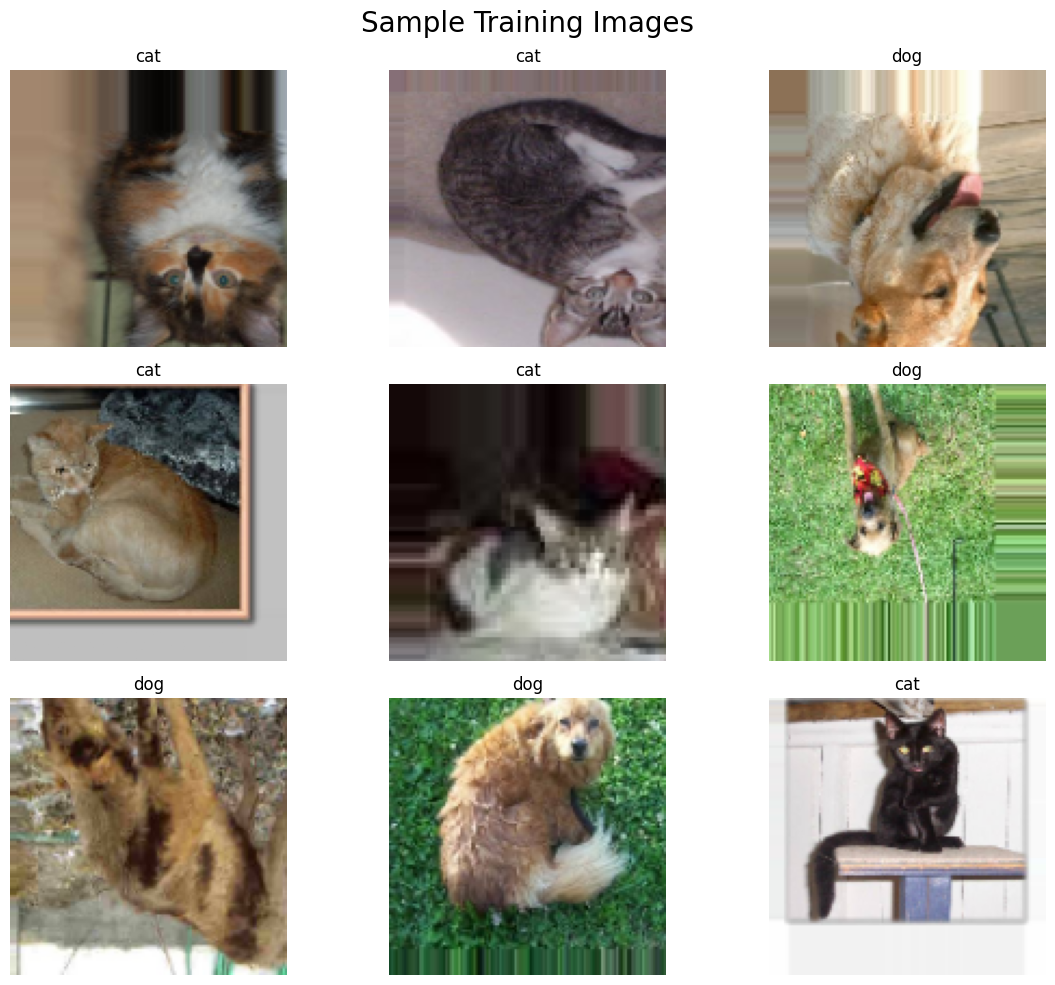

In [ ]:
fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize = (12, 10))
idx = 0
plt.suptitle("Sample Training Images", fontsize = 20)
for i in range(3):
    for j in range(3):
        label = labels[train_generator[0][1][idx]]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.show()

In [ ]:
## Training a pretrained model using transfer learning

base_model = VGG16(input_shape = IMG_SHAPE, include_top=False, weights='imagenet')

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# Freeze top layer of the base model
base_model.trainable = False
# add classification layers
inputs = Input(shape = IMG_SHAPE)
x = base_model(inputs, training = False)
#My lines
x = Dense(8192, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs = inputs, outputs = outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 dense (Dense)               (None, 4, 4, 8192)        4202496   
                                                                 
 dropout (Dropout)           (None, 4, 4, 8192)        0         
                                                                 
 dense_1 (Dense)             (None, 4, 4, 4096)        33558528  
                                                                 
 dropout_1 (Dropout)         (None, 4, 4, 4096)        0         
                                                                 
 global_average_pooling2d (  (None, 4096)              0     

In [ ]:
## Reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                            factor=np.sqrt(0.1),
                             patience=5)

# Defining the Optimizer
base_learning_rate = 0.00001
optimizer = Adam(learning_rate=base_learning_rate)

# Compile the Model
model.compile(
    optimizer = optimizer,
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
# Sample first iteration:

loss_0, accuracy_0 = model.evaluate(test_generator)

print(f"Initial Loss: {loss_0:.2f}")
print(f"Initial Accuracy: {accuracy_0: .2f}")

74/74 [==============================] - 669s 9s/step - loss: 0.6932 - accuracy: 0.5052
Initial Loss: 0.69
Initial Accuracy:  0.51


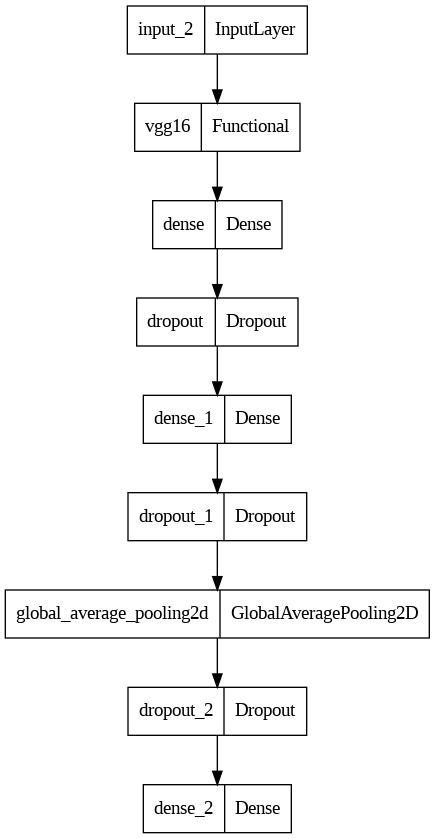

In [ ]:
# Model CheckPointer
from datetime import datetime
freq = 20
# Folder setup
init_time = datetime.now()
current_time = init_time.strftime('%Y%m%d_%H%M%S')
name_dir = DirPath + '/midterm/trained_models_' + current_time
os.mkdir(name_dir)

# Callbacks1: ModelCheckpointer
model_file_format = name_dir + '/model_' + str(fold_num) + '_model.{epoch:04d}.hdf5'
check = ModelCheckpoint(model_file_format, save_freq = freq, verbose = 1)

# Callbacks2: TensorBoard
tensor_check = name_dir + '/logs/' + current_time + '_train_testsplit'
tensor_board = TensorBoard(tensor_check)

# Callbacks3: EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

figure_name = name_dir + '/model_output.png'
tf.keras.utils.plot_model(model,figure_name)

In [ ]:
from tensorflow.keras.callbacks import Callback

class SaveModelAfterEachEpoch(Callback):
    def __init__(self, name_dir, foldx_num):
        super(SaveModelAfterEachEpoch, self).__init__()
        self.name_dir = name_dir
        self.fold_num = fold_num

    def on_epoch_end(self, epoch, logs=None):
        model_name = f"{self.name_dir}/model_2_model.{epoch + 1:04d}.hdf5"
        self.model.save(model_name)
        print(f"Epoch {epoch + 1}: Model saved to {model_name}")


class SaveModelAfterFirstEpoch(Callback):
  def on_epoch_end(self,epoch,logs=None):
    if epoch ==0:
      self.model.save(name_dir  +"/model_after_first_epoch.hdf5")

In [ ]:
# Specify the name_dir and fold_num for the callback
# name_dir defined above
foldx_num = 1
#save_first_epoch_callback = SaveModelAfterFirstEpoch()
# Create an instance of the SaveModelAfterEachEpoch callback
save_callback = SaveModelAfterEachEpoch(name_dir, fold_num)

In [ ]:
# Training the Model

initial_epochs = 15

history = model.fit(train_generator,
                    epochs=initial_epochs,
                    validation_data=validation_generator,
                    callbacks=[check, tensor_board,early_stop,save_callback])


early_stop_name = name_dir + '/fold_num_' + str(fold_num) + 'early_stop_model.hdf5'
model.save_weights(early_stop_name)

Epoch 1/15
 19/589 [..............................] - ETA: 1:28:56 - loss: 0.7001 - accuracy: 0.5093
Epoch 1: saving model to /content/drive/MyDrive/AI//midterm/trained_models_20231105_001653/model_2_model.0001.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


 39/589 [>.............................] - ETA: 1:26:10 - loss: 0.6950 - accuracy: 0.5143
Epoch 1: saving model to /content/drive/MyDrive/AI//midterm/trained_models_20231105_001653/model_2_model.0001.hdf5
 59/589 [==>...........................] - ETA: 1:22:41 - loss: 0.6885 - accuracy: 0.5309
Epoch 1: saving model to /content/drive/MyDrive/AI//midterm/trained_models_20231105_001653/model_2_model.0001.hdf5
 79/589 [===>..........................] - ETA: 1:18:50 - loss: 0.6843 - accuracy: 0.5458
Epoch 1: saving model to /content/drive/MyDrive/AI//midterm/trained_models_20231105_001653/model_2_model.0001.hdf5
 99/589 [====>.........................] - ETA: 1:16:38 - loss: 0.6800 - accuracy: 0.5585
Epoch 1: saving model to /content/drive/MyDrive/AI//midterm/trained_models_20231105_001653/model_2_model.0001.hdf5
119/589 [=====>........................] - ETA: 1:13:45 - loss: 0.6729 - accuracy: 0.5774
Epoch 1: saving model to /content/drive/MyDrive/AI//midterm/trained_models_20231105_001653

KeyboardInterrupt: ignored

In [ ]:
last_epoch = 0
# Load the previously saved model
model = tf.keras.models.load_model('/content/drive/MyDrive/AI/midterm/trained_models_20231105_001653/model_2_model.0001.hdf5')

foldx_num = 1
# Create an instance of the SaveModelAfterEachEpoch callback
save_callback = SaveModelAfterEachEpoch(name_dir, foldx_num)

# Specify the new epoch range
num_epochs = 15

history = model.fit(train_generator,
                    initial_epoch=last_epoch + 1,
                    epochs=num_epochs + last_epoch,
                    validation_data=validation_generator,
                    callbacks=[check, tensor_board,early_stop,save_callback,reduce_lr])


early_stop_name = name_dir + '/fold_num_' + str(fold_num) + '/early_stop_model.hdf5'
model.save_weights(early_stop_name)


# Continue training the m

Epoch 2/15
 19/589 [..............................] - ETA: 1:29:46 - loss: 0.5011 - accuracy: 0.7430
Epoch 2: saving model to /content/drive/MyDrive/AI//midterm/trained_models_20231105_133623/model_2_model.0002.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


 39/589 [>.............................] - ETA: 1:27:07 - loss: 0.4832 - accuracy: 0.7647
Epoch 2: saving model to /content/drive/MyDrive/AI//midterm/trained_models_20231105_133623/model_2_model.0002.hdf5
 59/589 [==>...........................] - ETA: 1:25:05 - loss: 0.4880 - accuracy: 0.7652
Epoch 2: saving model to /content/drive/MyDrive/AI//midterm/trained_models_20231105_133623/model_2_model.0002.hdf5
 79/589 [===>..........................] - ETA: 1:21:45 - loss: 0.4891 - accuracy: 0.7647
Epoch 2: saving model to /content/drive/MyDrive/AI//midterm/trained_models_20231105_133623/model_2_model.0002.hdf5
 99/589 [====>.........................] - ETA: 1:18:49 - loss: 0.4870 - accuracy: 0.7686
Epoch 2: saving model to /content/drive/MyDrive/AI//midterm/trained_models_20231105_133623/model_2_model.0002.hdf5
119/589 [=====>........................] - ETA: 1:16:34 - loss: 0.4865 - accuracy: 0.7682
Epoch 2: saving model to /content/drive/MyDrive/AI//midterm/trained_models_20231105_133623

FileNotFoundError: ignored

In [ ]:
# Plotting the training and validation accuracy, loss and learning rate
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['lr']

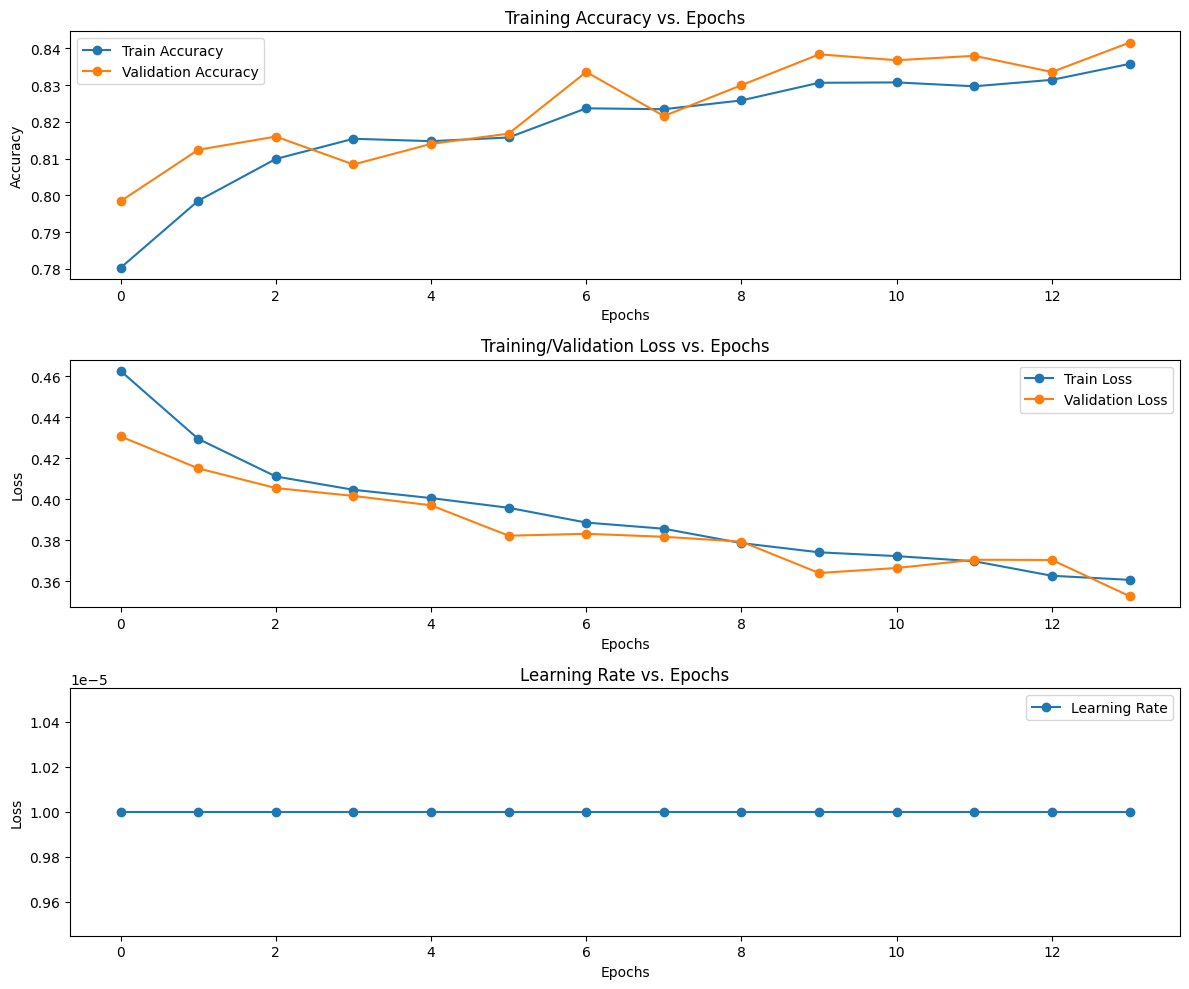

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

In [ ]:
predictions = model.predict(test_generator)

74/74 [==============================] - 695s 10s/step


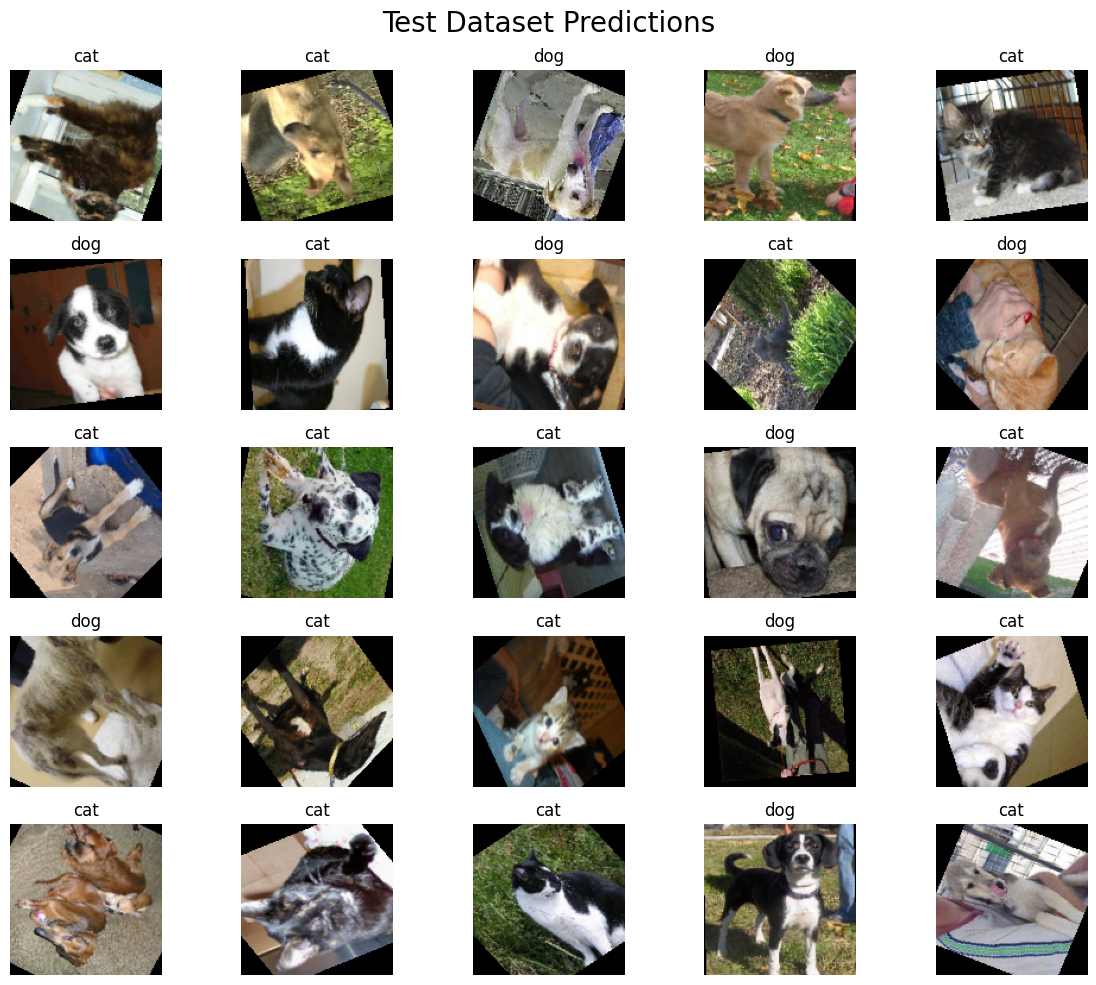

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(12, 10))
idx = 0
plt.suptitle('Test Dataset Predictions', fontsize=20)

for i in range(5):
    for j in range(5):
        predicted_label = labels[np.round(predictions.T[0][idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, batch_size=BATCH_SIZE)

print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

74/74 [==============================] - 18s 240ms/step - loss: 0.4848 - accuracy: 0.7616
Test Loss:     0.4848026931285858
Test Accuracy: 0.7616000175476074


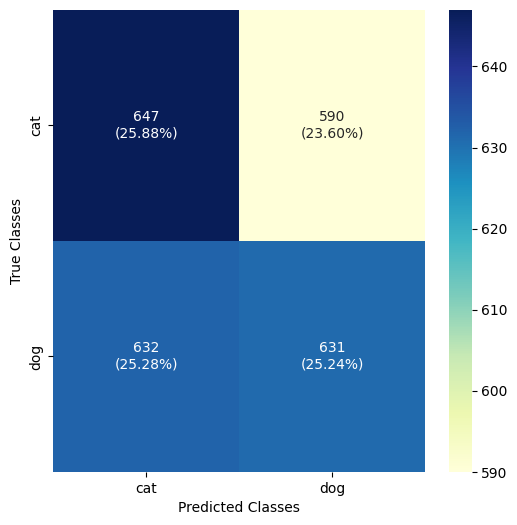

In [ ]:
y_pred = np.round(predictions)
y_pred = y_pred.T[0]          # to make the shape of y_true and y_pred same
y_true = test_generator.classes
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(2, 2)

plt.figure(figsize = (6, 6))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)

plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [ ]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

              precision    recall  f1-score   support

         cat       0.51      0.52      0.51      1237
         dog       0.52      0.50      0.51      1263

    accuracy                           0.51      2500
   macro avg       0.51      0.51      0.51      2500
weighted avg       0.51      0.51      0.51      2500



## Training SRGAN

Found 7 validated image filenames belonging to 1 classes.


/Users/kimsourthach/Documents/2023-School-Docs/classes/midterm-GAN/.env/lib/python3.9/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 20074 invalid image filename(s) in x_col="Filename". These filename(s) will be ignored.
  warnings.warn(


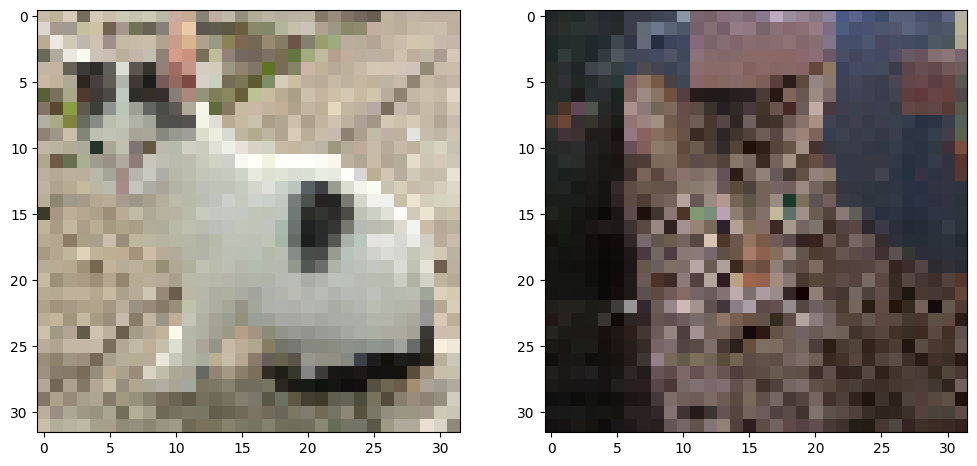

1


In [7]:
# Define the image data generator without augmentations
train_datagen = ImageDataGenerator(rescale=1.0/255)

# Specify the directory containing the images
train_directory = 'small-training/train/'  # Replace with the actual path to the training directory

# Generate batches of data from the dataframe without augmentations
train_generator_low_res = train_datagen.flow_from_dataframe(dataframe= df_train,
                                                      directory= train_directory,  # Replace with the actual path to the image directory
                                                      x_col='Filename',
                                                      y_col='Class',
                                                      target_size=(32, 32),
                                                      batch_size=32,
                                                      class_mode='binary',
                                                      shuffle=False)

# Visualize 2 images from the batch
images, labels = next(train_generator_low_res)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.axis('on')
plt.show()
print(i)


Found 7 validated image filenames belonging to 1 classes.


/Users/kimsourthach/Documents/2023-School-Docs/classes/midterm-GAN/.env/lib/python3.9/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 20074 invalid image filename(s) in x_col="Filename". These filename(s) will be ignored.
  warnings.warn(


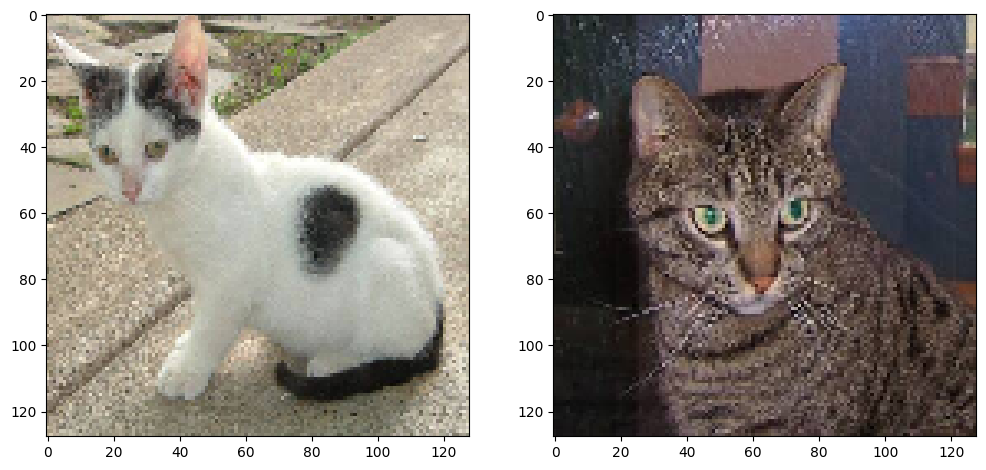

In [8]:
# Define the image data generator without augmentations
train_datagen = ImageDataGenerator(rescale=1.0/255)

# Specify the directory containing the images
train_directory = 'small-training/train/'  # Replace with the actual path to the training directory

# Generate batches of data from the dataframe without augmentations
train_generator_targ_res = train_datagen.flow_from_dataframe(dataframe= df_train,
                                                      directory= train_directory,  # Replace with the actual path to the image directory
                                                      x_col='Filename',
                                                      y_col='Class',
                                                      target_size=(128, 128),
                                                      batch_size=32,
                                                      class_mode='binary',
                                                      shuffle=False)

# Visualize 2 images from the batch
images, labels = next(train_generator_targ_res)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.axis('on')
plt.show()


In [34]:
for i in range(5):  # Display 5 batches of images
    batch = next(train_generator_hq_res)
    for image in batch:
        print(f"Image shape: {image.shape}") 

Image shape: (7, 256, 256, 3)
Image shape: (7,)
Image shape: (7, 256, 256, 3)
Image shape: (7,)
Image shape: (7, 256, 256, 3)
Image shape: (7,)
Image shape: (7, 256, 256, 3)
Image shape: (7,)
Image shape: (7, 256, 256, 3)
Image shape: (7,)


Found 7 validated image filenames belonging to 1 classes.


/Users/kimsourthach/Documents/2023-School-Docs/classes/midterm-GAN/.env/lib/python3.9/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 20074 invalid image filename(s) in x_col="Filename". These filename(s) will be ignored.
  warnings.warn(


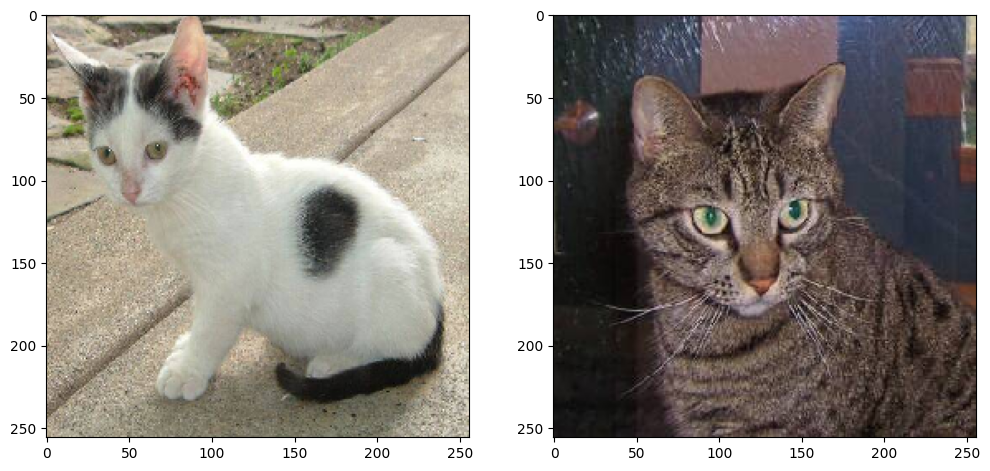

In [9]:
# Define the image data generator without augmentations
train_datagen = ImageDataGenerator(rescale=1.0/255)

# Specify the directory containing the images
train_directory = 'small-training/train/'  # Replace with the actual path to the training directory

# Generate batches of data from the dataframe without augmentations
train_generator_hq_res = train_datagen.flow_from_dataframe(dataframe= df_train,
                                                      directory= train_directory,  # Replace with the actual path to the image directory
                                                      x_col='Filename',
                                                      y_col='Class',
                                                      batch_size=32,
                                                      class_mode='binary',
                                                      shuffle=False)

# Visualize 2 images from the batch
images, labels = next(train_generator_hq_res)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.axis('on')
plt.show()

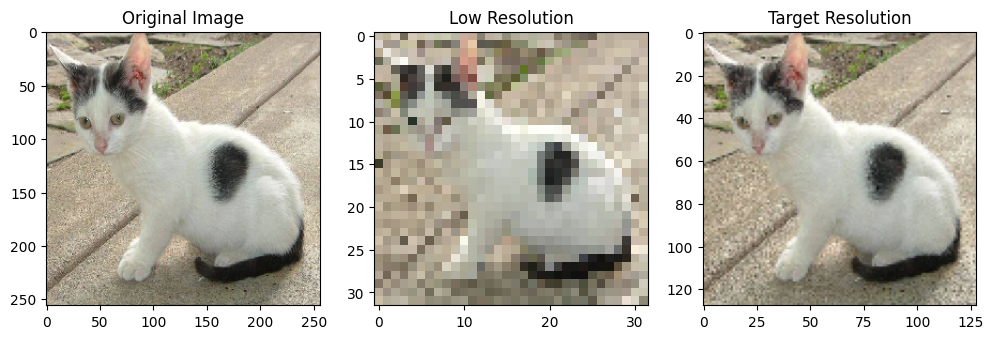

In [11]:
fig, axes = plt.subplots(1, 3,figsize=(12, 6))
original_image = train_generator_hq_res[0][0][0]
low_res = train_generator_low_res[0][0][0]
targ_res = train_generator_targ_res[0][0][0]

axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[0].axis('on')

axes[1].imshow(low_res)
axes[1].set_title('Low Resolution')
axes[1].axis('on')

axes[2].imshow(targ_res)
axes[2].set_title('Target Resolution')
axes[2].axis('on')

plt.show()


ValueError: Exception encountered when calling layer "sequential_21" (type Sequential).

Input 0 of layer "dense_19" is incompatible with the layer: expected axis -1 of input shape to have value 100, but received input with shape (None, 32, 32, 3)

Call arguments received by layer "sequential_21" (type Sequential):
  • inputs=tf.Tensor(shape=(None, 32, 32, 3), dtype=float32)
  • training=None
  • mask=None

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers

# Define the generator architecture
def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 32, 32, 3)

    return model

# Define the discriminator architecture
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

# Create instances of the generator and discriminator
generator = build_generator()
discriminator = build_discriminator()

# Define the SRGAN model
def build_srgan(generator, discriminator):
    sr_model = tf.keras.Sequential()
    sr_model.add(generator)
    discriminator.trainable = False  # Make sure the discriminator is not trainable in the combined model
    sr_model.add(discriminator)
    return sr_model

srgan = build_srgan(generator, discriminator)

# Compile the SRGAN model
srgan.compile(optimizer=optimizers.Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy')
srgan.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 32, 32, 3)         2733504   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 217985    
                                                                 
Total params: 2951489 (11.26 MB)
Trainable params: 2700352 (10.30 MB)
Non-trainable params: 251137 (981.00 KB)
_________________________________________________________________


In [13]:
tf.keras.utils.plot_model(srgan)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [26]:
# Generate a batch of low-resolution images using the image generator
low_res_images = next(train_generator_low_res)
ls = low_res_images[0][0][1]

# Generate high-resolution images from the low-resolution inputs using the SRGAN model
generated_images = srgan(low_res_images)

ValueError: Layer "sequential_11" expects 1 input(s), but it received 2 input tensors. Inputs received: [<tf.Tensor: shape=(7, 32, 32, 3), dtype=float32, numpy=
array([[[[0.7803922 , 0.7372549 , 0.6666667 ],
         [0.74509805, 0.7058824 , 0.6       ],
         [0.8470589 , 0.7960785 , 0.73333335],
         ...,
         [0.74509805, 0.69411767, 0.627451  ],
         [0.7411765 , 0.6901961 , 0.627451  ],
         [0.74509805, 0.69411767, 0.6313726 ]],

        [[0.86666673, 0.83921576, 0.81568635],
         [0.654902  , 0.6       , 0.54901963],
         [0.6313726 , 0.6039216 , 0.5647059 ],
         ...,
         [0.78823537, 0.7372549 , 0.6627451 ],
         [0.79215693, 0.7411765 , 0.6745098 ],
         [0.74509805, 0.6862745 , 0.6117647 ]],

        [[0.7294118 , 0.6745098 , 0.57254905],
         [0.92549026, 0.9058824 , 0.882353  ],
         [0.8196079 , 0.7843138 , 0.7176471 ],
         ...,
         [0.8196079 , 0.7725491 , 0.6862745 ],
         [0.7803922 , 0.7254902 , 0.6745098 ],
         [0.7686275 , 0.7137255 , 0.67058825]],

        ...,

        [[0.5176471 , 0.4666667 , 0.4039216 ],
         [0.68235296, 0.63529414, 0.54901963],
         [0.5921569 , 0.5411765 , 0.47450984],
         ...,
         [0.5568628 , 0.50980395, 0.454902  ],
         [0.58431375, 0.56078434, 0.49803925],
         [0.8235295 , 0.8000001 , 0.75294125]],

        [[0.73333335, 0.68235296, 0.60784316],
         [0.60784316, 0.56078434, 0.5137255 ],
         [0.6745098 , 0.654902  , 0.5803922 ],
         ...,
         [0.6392157 , 0.5921569 , 0.54509807],
         [0.8078432 , 0.78823537, 0.7137255 ],
         [0.7960785 , 0.77647066, 0.7019608 ]],

        [[0.79215693, 0.74509805, 0.65882355],
         [0.69803923, 0.6784314 , 0.6039216 ],
         [0.72156864, 0.7019608 , 0.627451  ],
         ...,
         [0.92549026, 0.87843144, 0.8313726 ],
         [0.854902  , 0.8313726 , 0.77647066],
         [0.56078434, 0.5372549 , 0.47450984]]],


       [[[0.12941177, 0.14509805, 0.15686275],
         [0.15294118, 0.17254902, 0.15686275],
         [0.12941177, 0.16470589, 0.16078432],
         ...,
         [0.28235295, 0.30980393, 0.41176474],
         [0.36862746, 0.39607847, 0.49803925],
         [0.7058824 , 0.69411767, 0.627451  ]],

        [[0.14901961, 0.16470589, 0.1764706 ],
         [0.16470589, 0.18431373, 0.16862746],
         [0.16862746, 0.20392159, 0.20000002],
         ...,
         [0.29411766, 0.3254902 , 0.40000004],
         [0.30588236, 0.3372549 , 0.41176474],
         [0.7176471 , 0.69411767, 0.5921569 ]],

        [[0.12156864, 0.15686275, 0.15294118],
         [0.13725491, 0.17254902, 0.16862746],
         [0.14509805, 0.18039216, 0.1764706 ],
         ...,
         [0.30588236, 0.34509805, 0.3921569 ],
         [0.2901961 , 0.33333334, 0.35686275],
         [0.68235296, 0.654902  , 0.58431375]],

        ...,

        [[0.0627451 , 0.0627451 , 0.0627451 ],
         [0.06666667, 0.06666667, 0.06666667],
         [0.0509804 , 0.0509804 , 0.0509804 ],
         ...,
         [0.34117648, 0.28627452, 0.2509804 ],
         [0.37254903, 0.31764707, 0.27450982],
         [0.12941177, 0.07058824, 0.0509804 ]],

        [[0.09411766, 0.09411766, 0.09411766],
         [0.09803922, 0.09803922, 0.09803922],
         [0.10196079, 0.10196079, 0.10196079],
         ...,
         [0.29411766, 0.25882354, 0.23137257],
         [0.2901961 , 0.25490198, 0.227451  ],
         [0.36078432, 0.3019608 , 0.28235295]],

        [[0.07450981, 0.06666667, 0.07058824],
         [0.07843138, 0.07058824, 0.07450981],
         [0.10196079, 0.09803922, 0.09019608],
         ...,
         [0.23529413, 0.16862746, 0.14117648],
         [0.23137257, 0.16078432, 0.14509805],
         [0.19607845, 0.13725491, 0.11764707]]],


       [[[0.627451  , 0.58431375, 0.56078434],
         [0.69803923, 0.654902  , 0.6313726 ],
         [0.73333335, 0.6745098 , 0.654902  ],
         ...,
         [0.63529414, 0.6117647 , 0.54901963],
         [0.5176471 , 0.38431376, 0.3803922 ],
         [0.5921569 , 0.5568628 , 0.5372549 ]],

        [[0.6156863 , 0.5882353 , 0.5568628 ],
         [0.74509805, 0.6862745 , 0.6666667 ],
         [0.7490196 , 0.6901961 , 0.67058825],
         ...,
         [0.59607846, 0.54509807, 0.52156866],
         [0.7294118 , 0.6862745 , 0.67058825],
         [0.6745098 , 0.6431373 , 0.63529414]],

        [[0.63529414, 0.60784316, 0.5764706 ],
         [0.74509805, 0.6862745 , 0.6666667 ],
         [0.7686275 , 0.70980394, 0.6901961 ],
         ...,
         [0.8235295 , 0.7058824 , 0.7058824 ],
         [0.7960785 , 0.7607844 , 0.7019608 ],
         [0.7843138 , 0.7254902 , 0.7058824 ]],

        ...,

        [[0.75294125, 0.69803923, 0.64705884],
         [0.2784314 , 0.2392157 , 0.19215688],
         [0.7411765 , 0.69803923, 0.6901961 ],
         ...,
         [0.08627451, 0.08627451, 0.08627451],
         [0.2392157 , 0.2509804 , 0.3254902 ],
         [0.2392157 , 0.23137257, 0.3254902 ]],

        [[0.14901961, 0.13333334, 0.12941177],
         [0.16862746, 0.12941177, 0.08235294],
         [0.4666667 , 0.43529415, 0.3921569 ],
         ...,
         [0.1254902 , 0.1137255 , 0.14117648],
         [0.09411766, 0.09803922, 0.11764707],
         [0.19607845, 0.20392159, 0.2627451 ]],

        [[0.06666667, 0.07058824, 0.04705883],
         [0.08235294, 0.06666667, 0.05490196],
         [0.10196079, 0.09019608, 0.03137255],
         ...,
         [0.0509804 , 0.04705883, 0.07058824],
         [0.01568628, 0.0509804 , 0.03921569],
         [0.02745098, 0.05490196, 0.07843138]]],


       ...,


       [[[0.7607844 , 0.7137255 , 0.8078432 ],
         [0.27058825, 0.18823531, 0.25490198],
         [0.24705884, 0.20392159, 0.227451  ],
         ...,
         [0.4156863 , 0.3372549 , 0.3019608 ],
         [0.6117647 , 0.58431375, 0.5137255 ],
         [0.5764706 , 0.5254902 , 0.46274513]],

        [[0.8352942 , 0.8078432 , 0.8705883 ],
         [0.7490196 , 0.76470596, 0.8117648 ],
         [0.6862745 , 0.72156864, 0.78823537],
         ...,
         [0.39607847, 0.32941177, 0.2901961 ],
         [0.5529412 , 0.54509807, 0.49803925],
         [0.5803922 , 0.5529412 , 0.4901961 ]],

        [[0.8470589 , 0.854902  , 0.9058824 ],
         [0.8196079 , 0.7843138 , 0.85098046],
         [0.7803922 , 0.78823537, 0.8352942 ],
         ...,
         [0.46274513, 0.40000004, 0.34901962],
         [0.65882355, 0.654902  , 0.5764706 ],
         [0.5882353 , 0.56078434, 0.49803925]],

        ...,

        [[0.7607844 , 0.7372549 , 0.79215693],
         [0.627451  , 0.60784316, 0.62352943],
         [0.5411765 , 0.5411765 , 0.57254905],
         ...,
         [0.17254902, 0.1254902 , 0.20392159],
         [0.24705884, 0.21176472, 0.2784314 ],
         [0.19607845, 0.16078432, 0.23529413]],

        [[0.7725491 , 0.7254902 , 0.76470596],
         [0.7019608 , 0.68235296, 0.7058824 ],
         [0.5411765 , 0.5411765 , 0.57254905],
         ...,
         [0.14901961, 0.1137255 , 0.19607845],
         [0.2627451 , 0.227451  , 0.3019608 ],
         [0.227451  , 0.1764706 , 0.25490198]],

        [[0.40000004, 0.34901962, 0.38823533],
         [0.7137255 , 0.6901961 , 0.69803923],
         [0.5686275 , 0.5568628 , 0.6       ],
         ...,
         [0.20784315, 0.17254902, 0.25490198],
         [0.22352943, 0.18823531, 0.25490198],
         [0.16470589, 0.12156864, 0.18823531]]],


       [[[0.8235295 , 0.67058825, 0.36862746],
         [0.87843144, 0.70980394, 0.4039216 ],
         [0.9215687 , 0.75294125, 0.44705886],
         ...,
         [0.9960785 , 0.89019614, 0.6117647 ],
         [0.9803922 , 0.854902  , 0.56078434],
         [0.9607844 , 0.8117648 , 0.49411768]],

        [[0.8313726 , 0.65882355, 0.37254903],
         [0.86666673, 0.69411767, 0.40000004],
         [0.90196085, 0.7294118 , 0.43529415],
         ...,
         [0.9803922 , 0.9058824 , 0.63529414],
         [0.9803922 , 0.854902  , 0.56078434],
         [0.9568628 , 0.8431373 , 0.5372549 ]],

        [[0.8313726 , 0.65882355, 0.37254903],
         [0.86274517, 0.6901961 , 0.39607847],
         [0.8745099 , 0.7019608 , 0.40784317],
         ...,
         [0.9803922 , 0.9058824 , 0.63529414],
         [0.9843138 , 0.8588236 , 0.5647059 ],
         [0.97647065, 0.8588236 , 0.5764706 ]],

        ...,

        [[0.6784314 , 0.53333336, 0.25490198],
         [0.6901961 , 0.54509807, 0.26666668],
         [0.6784314 , 0.54509807, 0.25490198],
         ...,
         [0.03921569, 0.03921569, 0.00784314],
         [0.04313726, 0.03921569, 0.01960784],
         [0.03529412, 0.03137255, 0.01176471]],

        [[0.6509804 , 0.5176471 , 0.2392157 ],
         [0.6784314 , 0.53333336, 0.25490198],
         [0.68235296, 0.54901963, 0.26666668],
         ...,
         [0.01960784, 0.02352941, 0.00392157],
         [0.01568628, 0.01960784, 0.        ],
         [0.01568628, 0.01960784, 0.        ]],

        [[0.6156863 , 0.49803925, 0.22352943],
         [0.6509804 , 0.5176471 , 0.23529413],
         [0.68235296, 0.54901963, 0.26666668],
         ...,
         [0.01568628, 0.01568628, 0.00784314],
         [0.01176471, 0.01176471, 0.00392157],
         [0.01176471, 0.01176471, 0.00392157]]],


       [[[0.        , 0.        , 0.01568628],
         [0.00784314, 0.00392157, 0.02352941],
         [0.00784314, 0.00392157, 0.02352941],
         ...,
         [0.9686275 , 1.        , 1.        ],
         [0.91372555, 0.9843138 , 0.9843138 ],
         [0.9333334 , 0.9960785 , 0.9921569 ]],

        [[0.        , 0.03137255, 0.04313726],
         [0.01176471, 0.        , 0.02745098],
         [0.02352941, 0.        , 0.02745098],
         ...,
         [0.34509805, 0.46274513, 0.43137258],
         [0.19607845, 0.3254902 , 0.29803923],
         [0.20784315, 0.28627452, 0.2901961 ]],

        [[0.0509804 , 0.09411766, 0.11764707],
         [0.27058825, 0.32156864, 0.34509805],
         [0.00784314, 0.06666667, 0.08627451],
         ...,
         [0.28627452, 0.30588236, 0.2901961 ],
         [0.24705884, 0.28627452, 0.2901961 ],
         [0.25882354, 0.26666668, 0.3137255 ]],

        ...,

        [[0.5411765 , 0.6039216 , 0.6       ],
         [0.89019614, 0.9725491 , 0.95294124],
         [0.90196085, 0.9803922 , 1.        ],
         ...,
         [0.95294124, 1.        , 0.9921569 ],
         [0.94117653, 1.        , 0.9921569 ],
         [0.9725491 , 0.9960785 , 0.9960785 ]],

        [[0.8941177 , 1.        , 0.98823535],
         [0.43137258, 0.54901963, 0.5921569 ],
         [0.22352943, 0.3529412 , 0.427451  ],
         ...,
         [0.98823535, 0.9725491 , 0.9686275 ],
         [0.9843138 , 1.        , 0.98823535],
         [0.9843138 , 0.9921569 , 0.9803922 ]],

        [[0.29803923, 0.40784317, 0.454902  ],
         [0.16470589, 0.2784314 , 0.39607847],
         [0.30588236, 0.427451  , 0.5372549 ],
         ...,
         [0.9803922 , 1.        , 1.        ],
         [0.8941177 , 1.        , 0.9921569 ],
         [0.67058825, 0.83921576, 0.80392164]]]], dtype=float32)>, <tf.Tensor: shape=(7,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0.], dtype=float32)>]

In [36]:
# Define your image generator
# ...

# Define your SRGAN architecture and compile it
# ...
epochs = 2
num_steps = 2
# Training loop
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}")
    for step in range(num_steps):
        # Generate a batch of low-resolution images using the image generator
        low_res_images = next(train_generator_low_res)
        high_res_images = next(train_generator_hq_res)
        #low_res_image = train_generator[0][0][step]
        # Upsample low-resolution images to 128 x 128 using your preferred method
        upscaled_image = next(train_generator_targ_res)

        # Generate high-resolution images from the low-resolution inputs using the SRGAN model
        generated_images = srgan(low_res_images)

        # Train the discriminator
        real_labels = tf.ones((len(low_res_images), 1))
        fake_labels = tf.zeros((len(low_res_images), 1))

        with tf.GradientTape() as tape:
            real_loss = losses.binary_crossentropy(real_labels, discriminator(high_res_images))
            fake_loss = losses.binary_crossentropy(fake_labels, discriminator(generated_images))
            total_discriminator_loss = real_loss + fake_loss

        gradients_of_discriminator = tape.gradient(total_discriminator_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as tape:
            adversarial_loss = losses.binary_crossentropy(real_labels, discriminator(high_res_images))
            content_loss = losses.mean_absolute_error(high_res_images, generated_images)
            total_generator_loss = content_loss + 1e-3 * adversarial_loss

        gradients_of_generator = tape.gradient(total_generator_loss, srgan.trainable_variables)
        srgan_optimizer.apply_gradients(zip(gradients_of_generator, srgan.trainable_variables))

        # Print the progress
        if step % 100 == 0:
            print(f"Epoch {epoch + 1}, Step {step}, Generator Loss: {float(total_generator_loss)}, Discriminator Loss: {float(total_discriminator_loss)}")


Epoch 1


ValueError: Layer "sequential_2" expects 1 input(s), but it received 2 input tensors. Inputs received: [<tf.Tensor: shape=(7, 32, 32, 3), dtype=float32, numpy=
array([[[[0.7803922 , 0.7372549 , 0.6666667 ],
         [0.74509805, 0.7058824 , 0.6       ],
         [0.8470589 , 0.7960785 , 0.73333335],
         ...,
         [0.74509805, 0.69411767, 0.627451  ],
         [0.7411765 , 0.6901961 , 0.627451  ],
         [0.74509805, 0.69411767, 0.6313726 ]],

        [[0.86666673, 0.83921576, 0.81568635],
         [0.654902  , 0.6       , 0.54901963],
         [0.6313726 , 0.6039216 , 0.5647059 ],
         ...,
         [0.78823537, 0.7372549 , 0.6627451 ],
         [0.79215693, 0.7411765 , 0.6745098 ],
         [0.74509805, 0.6862745 , 0.6117647 ]],

        [[0.7294118 , 0.6745098 , 0.57254905],
         [0.92549026, 0.9058824 , 0.882353  ],
         [0.8196079 , 0.7843138 , 0.7176471 ],
         ...,
         [0.8196079 , 0.7725491 , 0.6862745 ],
         [0.7803922 , 0.7254902 , 0.6745098 ],
         [0.7686275 , 0.7137255 , 0.67058825]],

        ...,

        [[0.5176471 , 0.4666667 , 0.4039216 ],
         [0.68235296, 0.63529414, 0.54901963],
         [0.5921569 , 0.5411765 , 0.47450984],
         ...,
         [0.5568628 , 0.50980395, 0.454902  ],
         [0.58431375, 0.56078434, 0.49803925],
         [0.8235295 , 0.8000001 , 0.75294125]],

        [[0.73333335, 0.68235296, 0.60784316],
         [0.60784316, 0.56078434, 0.5137255 ],
         [0.6745098 , 0.654902  , 0.5803922 ],
         ...,
         [0.6392157 , 0.5921569 , 0.54509807],
         [0.8078432 , 0.78823537, 0.7137255 ],
         [0.7960785 , 0.77647066, 0.7019608 ]],

        [[0.79215693, 0.74509805, 0.65882355],
         [0.69803923, 0.6784314 , 0.6039216 ],
         [0.72156864, 0.7019608 , 0.627451  ],
         ...,
         [0.92549026, 0.87843144, 0.8313726 ],
         [0.854902  , 0.8313726 , 0.77647066],
         [0.56078434, 0.5372549 , 0.47450984]]],


       [[[0.12941177, 0.14509805, 0.15686275],
         [0.15294118, 0.17254902, 0.15686275],
         [0.12941177, 0.16470589, 0.16078432],
         ...,
         [0.28235295, 0.30980393, 0.41176474],
         [0.36862746, 0.39607847, 0.49803925],
         [0.7058824 , 0.69411767, 0.627451  ]],

        [[0.14901961, 0.16470589, 0.1764706 ],
         [0.16470589, 0.18431373, 0.16862746],
         [0.16862746, 0.20392159, 0.20000002],
         ...,
         [0.29411766, 0.3254902 , 0.40000004],
         [0.30588236, 0.3372549 , 0.41176474],
         [0.7176471 , 0.69411767, 0.5921569 ]],

        [[0.12156864, 0.15686275, 0.15294118],
         [0.13725491, 0.17254902, 0.16862746],
         [0.14509805, 0.18039216, 0.1764706 ],
         ...,
         [0.30588236, 0.34509805, 0.3921569 ],
         [0.2901961 , 0.33333334, 0.35686275],
         [0.68235296, 0.654902  , 0.58431375]],

        ...,

        [[0.0627451 , 0.0627451 , 0.0627451 ],
         [0.06666667, 0.06666667, 0.06666667],
         [0.0509804 , 0.0509804 , 0.0509804 ],
         ...,
         [0.34117648, 0.28627452, 0.2509804 ],
         [0.37254903, 0.31764707, 0.27450982],
         [0.12941177, 0.07058824, 0.0509804 ]],

        [[0.09411766, 0.09411766, 0.09411766],
         [0.09803922, 0.09803922, 0.09803922],
         [0.10196079, 0.10196079, 0.10196079],
         ...,
         [0.29411766, 0.25882354, 0.23137257],
         [0.2901961 , 0.25490198, 0.227451  ],
         [0.36078432, 0.3019608 , 0.28235295]],

        [[0.07450981, 0.06666667, 0.07058824],
         [0.07843138, 0.07058824, 0.07450981],
         [0.10196079, 0.09803922, 0.09019608],
         ...,
         [0.23529413, 0.16862746, 0.14117648],
         [0.23137257, 0.16078432, 0.14509805],
         [0.19607845, 0.13725491, 0.11764707]]],


       [[[0.627451  , 0.58431375, 0.56078434],
         [0.69803923, 0.654902  , 0.6313726 ],
         [0.73333335, 0.6745098 , 0.654902  ],
         ...,
         [0.63529414, 0.6117647 , 0.54901963],
         [0.5176471 , 0.38431376, 0.3803922 ],
         [0.5921569 , 0.5568628 , 0.5372549 ]],

        [[0.6156863 , 0.5882353 , 0.5568628 ],
         [0.74509805, 0.6862745 , 0.6666667 ],
         [0.7490196 , 0.6901961 , 0.67058825],
         ...,
         [0.59607846, 0.54509807, 0.52156866],
         [0.7294118 , 0.6862745 , 0.67058825],
         [0.6745098 , 0.6431373 , 0.63529414]],

        [[0.63529414, 0.60784316, 0.5764706 ],
         [0.74509805, 0.6862745 , 0.6666667 ],
         [0.7686275 , 0.70980394, 0.6901961 ],
         ...,
         [0.8235295 , 0.7058824 , 0.7058824 ],
         [0.7960785 , 0.7607844 , 0.7019608 ],
         [0.7843138 , 0.7254902 , 0.7058824 ]],

        ...,

        [[0.75294125, 0.69803923, 0.64705884],
         [0.2784314 , 0.2392157 , 0.19215688],
         [0.7411765 , 0.69803923, 0.6901961 ],
         ...,
         [0.08627451, 0.08627451, 0.08627451],
         [0.2392157 , 0.2509804 , 0.3254902 ],
         [0.2392157 , 0.23137257, 0.3254902 ]],

        [[0.14901961, 0.13333334, 0.12941177],
         [0.16862746, 0.12941177, 0.08235294],
         [0.4666667 , 0.43529415, 0.3921569 ],
         ...,
         [0.1254902 , 0.1137255 , 0.14117648],
         [0.09411766, 0.09803922, 0.11764707],
         [0.19607845, 0.20392159, 0.2627451 ]],

        [[0.06666667, 0.07058824, 0.04705883],
         [0.08235294, 0.06666667, 0.05490196],
         [0.10196079, 0.09019608, 0.03137255],
         ...,
         [0.0509804 , 0.04705883, 0.07058824],
         [0.01568628, 0.0509804 , 0.03921569],
         [0.02745098, 0.05490196, 0.07843138]]],


       ...,


       [[[0.7607844 , 0.7137255 , 0.8078432 ],
         [0.27058825, 0.18823531, 0.25490198],
         [0.24705884, 0.20392159, 0.227451  ],
         ...,
         [0.4156863 , 0.3372549 , 0.3019608 ],
         [0.6117647 , 0.58431375, 0.5137255 ],
         [0.5764706 , 0.5254902 , 0.46274513]],

        [[0.8352942 , 0.8078432 , 0.8705883 ],
         [0.7490196 , 0.76470596, 0.8117648 ],
         [0.6862745 , 0.72156864, 0.78823537],
         ...,
         [0.39607847, 0.32941177, 0.2901961 ],
         [0.5529412 , 0.54509807, 0.49803925],
         [0.5803922 , 0.5529412 , 0.4901961 ]],

        [[0.8470589 , 0.854902  , 0.9058824 ],
         [0.8196079 , 0.7843138 , 0.85098046],
         [0.7803922 , 0.78823537, 0.8352942 ],
         ...,
         [0.46274513, 0.40000004, 0.34901962],
         [0.65882355, 0.654902  , 0.5764706 ],
         [0.5882353 , 0.56078434, 0.49803925]],

        ...,

        [[0.7607844 , 0.7372549 , 0.79215693],
         [0.627451  , 0.60784316, 0.62352943],
         [0.5411765 , 0.5411765 , 0.57254905],
         ...,
         [0.17254902, 0.1254902 , 0.20392159],
         [0.24705884, 0.21176472, 0.2784314 ],
         [0.19607845, 0.16078432, 0.23529413]],

        [[0.7725491 , 0.7254902 , 0.76470596],
         [0.7019608 , 0.68235296, 0.7058824 ],
         [0.5411765 , 0.5411765 , 0.57254905],
         ...,
         [0.14901961, 0.1137255 , 0.19607845],
         [0.2627451 , 0.227451  , 0.3019608 ],
         [0.227451  , 0.1764706 , 0.25490198]],

        [[0.40000004, 0.34901962, 0.38823533],
         [0.7137255 , 0.6901961 , 0.69803923],
         [0.5686275 , 0.5568628 , 0.6       ],
         ...,
         [0.20784315, 0.17254902, 0.25490198],
         [0.22352943, 0.18823531, 0.25490198],
         [0.16470589, 0.12156864, 0.18823531]]],


       [[[0.8235295 , 0.67058825, 0.36862746],
         [0.87843144, 0.70980394, 0.4039216 ],
         [0.9215687 , 0.75294125, 0.44705886],
         ...,
         [0.9960785 , 0.89019614, 0.6117647 ],
         [0.9803922 , 0.854902  , 0.56078434],
         [0.9607844 , 0.8117648 , 0.49411768]],

        [[0.8313726 , 0.65882355, 0.37254903],
         [0.86666673, 0.69411767, 0.40000004],
         [0.90196085, 0.7294118 , 0.43529415],
         ...,
         [0.9803922 , 0.9058824 , 0.63529414],
         [0.9803922 , 0.854902  , 0.56078434],
         [0.9568628 , 0.8431373 , 0.5372549 ]],

        [[0.8313726 , 0.65882355, 0.37254903],
         [0.86274517, 0.6901961 , 0.39607847],
         [0.8745099 , 0.7019608 , 0.40784317],
         ...,
         [0.9803922 , 0.9058824 , 0.63529414],
         [0.9843138 , 0.8588236 , 0.5647059 ],
         [0.97647065, 0.8588236 , 0.5764706 ]],

        ...,

        [[0.6784314 , 0.53333336, 0.25490198],
         [0.6901961 , 0.54509807, 0.26666668],
         [0.6784314 , 0.54509807, 0.25490198],
         ...,
         [0.03921569, 0.03921569, 0.00784314],
         [0.04313726, 0.03921569, 0.01960784],
         [0.03529412, 0.03137255, 0.01176471]],

        [[0.6509804 , 0.5176471 , 0.2392157 ],
         [0.6784314 , 0.53333336, 0.25490198],
         [0.68235296, 0.54901963, 0.26666668],
         ...,
         [0.01960784, 0.02352941, 0.00392157],
         [0.01568628, 0.01960784, 0.        ],
         [0.01568628, 0.01960784, 0.        ]],

        [[0.6156863 , 0.49803925, 0.22352943],
         [0.6509804 , 0.5176471 , 0.23529413],
         [0.68235296, 0.54901963, 0.26666668],
         ...,
         [0.01568628, 0.01568628, 0.00784314],
         [0.01176471, 0.01176471, 0.00392157],
         [0.01176471, 0.01176471, 0.00392157]]],


       [[[0.        , 0.        , 0.01568628],
         [0.00784314, 0.00392157, 0.02352941],
         [0.00784314, 0.00392157, 0.02352941],
         ...,
         [0.9686275 , 1.        , 1.        ],
         [0.91372555, 0.9843138 , 0.9843138 ],
         [0.9333334 , 0.9960785 , 0.9921569 ]],

        [[0.        , 0.03137255, 0.04313726],
         [0.01176471, 0.        , 0.02745098],
         [0.02352941, 0.        , 0.02745098],
         ...,
         [0.34509805, 0.46274513, 0.43137258],
         [0.19607845, 0.3254902 , 0.29803923],
         [0.20784315, 0.28627452, 0.2901961 ]],

        [[0.0509804 , 0.09411766, 0.11764707],
         [0.27058825, 0.32156864, 0.34509805],
         [0.00784314, 0.06666667, 0.08627451],
         ...,
         [0.28627452, 0.30588236, 0.2901961 ],
         [0.24705884, 0.28627452, 0.2901961 ],
         [0.25882354, 0.26666668, 0.3137255 ]],

        ...,

        [[0.5411765 , 0.6039216 , 0.6       ],
         [0.89019614, 0.9725491 , 0.95294124],
         [0.90196085, 0.9803922 , 1.        ],
         ...,
         [0.95294124, 1.        , 0.9921569 ],
         [0.94117653, 1.        , 0.9921569 ],
         [0.9725491 , 0.9960785 , 0.9960785 ]],

        [[0.8941177 , 1.        , 0.98823535],
         [0.43137258, 0.54901963, 0.5921569 ],
         [0.22352943, 0.3529412 , 0.427451  ],
         ...,
         [0.98823535, 0.9725491 , 0.9686275 ],
         [0.9843138 , 1.        , 0.98823535],
         [0.9843138 , 0.9921569 , 0.9803922 ]],

        [[0.29803923, 0.40784317, 0.454902  ],
         [0.16470589, 0.2784314 , 0.39607847],
         [0.30588236, 0.427451  , 0.5372549 ],
         ...,
         [0.9803922 , 1.        , 1.        ],
         [0.8941177 , 1.        , 0.9921569 ],
         [0.67058825, 0.83921576, 0.80392164]]]], dtype=float32)>, <tf.Tensor: shape=(7,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0.], dtype=float32)>]

In [32]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import requests
import tensorflow_datasets as tfds
import tqdm
import os
import shutil
import re
import cv2
import time
import logging

In [34]:
class TqdmLoggingHandler(logging.Handler):
    def __init__(self, level=logging.NOTSET):
        super().__init__(level)

    def emit(self, record):
        try:
            msg = self.format(record)
            tqdm.tqdm.write(msg)
            self.flush()
        except (KeyboardInterrupt, SystemExit):
            raise
        except:
            self.handleError(record)  
log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
log.addHandler(TqdmLoggingHandler())

In [83]:
import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU, BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add

In [35]:
ds = tfds.load('cats_vs_dogs')

In [74]:
# Load the 'cats_vs_dogs' dataset
ds, info = tfds.load('cats_vs_dogs', split='train', with_info=True)

# Define the map function to modify the feature structure
def map_function(data):
    modified_data = {
        'image': data['image'],
        'label': tf.one_hot(data['label'], depth=5)  # Modify the label feature as required
    }
    return modified_data

# Apply the map function to the dataset
modified_ds = ds.map(map_function)

# Split the modified dataset into training and testing subsets
train_data = modified_ds.skip(600)
test_data = modified_ds.take(600)

# Extract the training and testing images and labels
train_lr, train_hr = zip(*train_data)
test_lr, test_hr = zip(*test_data)

# Check the datasets
for data in train_data.take(1):
    print("Training Data:", data)

for data in test_data.take(1):
    print("Testing Data:", data)




Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


Training Data: {'image': <tf.Tensor: shape=(374, 277, 3), dtype=uint8, numpy=
array([[[ 43,  36,  30],
        [ 43,  36,  30],
        [ 42,  35,  29],
        ...,
        [  7,   7,   7],
        [  8,   8,   8],
        [  8,   8,   8]],

       [[ 38,  31,  25],
        [ 38,  31,  25],
        [ 38,  31,  25],
        ...,
        [  2,   2,   2],
        [  2,   2,   2],
        [  3,   3,   3]],

       [[ 36,  29,  23],
        [ 37,  30,  24],
        [ 38,  31,  25],
        ...,
        [  2,   2,   2],
        [  3,   3,   3],
        [  3,   3,   3]],

       ...,

       [[200, 200, 192],
        [202, 202, 194],
        [201, 201, 193],
        ...,
        [150, 149, 147],
        [146, 145, 143],
        [149, 148, 144]],

       [[175, 175, 167],
        [175, 175, 167],
        [173, 173, 165],
        ...,
        [145, 144, 142],
        [139, 138, 136],
        [139, 138, 134]],

       [[178, 178, 170],
        [174, 174, 166],
        [168, 168, 160],
        .

In [75]:
lr_ip = Input(shape=(32,32,3))
hr_ip = Input(shape=(128,128,3))

In [77]:
# Residual block
def res_block(ip):

    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)

    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)

    return add([ip,res_model])

# Upscale the image 2x
def upscale_block(ip):    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)

    return up_model
num_res_block = 16

# Generator Model
def create_gen(gen_ip):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)
    temp = layers
    for i in range(num_res_block):
        layers = res_block(layers)
    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])
    layers = upscale_block(layers)
    layers = upscale_block(layers)
    op = Conv2D(3, (9,9), padding="same")(layers)
    return Model(inputs=gen_ip, outputs=op)

In [78]:
#Small block inside the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):

    disc_model = Conv2D(filters, (3,3), strides, padding="same")(ip)
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    return disc_model

# Discriminator Model
def create_disc(disc_ip):
    df = 64

    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)

    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)
    return Model(disc_ip, validity)

In [85]:
from keras.applications import VGG19
# Build the VGG19 model upto 10th layer 
# Used to extract the features of high res imgaes
def build_vgg():
    vgg = VGG19(weights="imagenet")
    vgg.outputs = [vgg.layers[9].output]
    img = Input(shape=(128,128,3))
    img_features = vgg(img)
    return Model(img, img_features)

In [80]:
# Attach the generator and discriminator
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    gen_features = vgg(gen_img)
    disc_model.trainable = False
    validity = disc_model(gen_img)
    return Model([lr_ip, hr_ip],[validity,gen_features])

In [86]:
generator = create_gen(lr_ip)
discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam",      
  metrics=['accuracy'])
vgg = build_vgg()
vgg.trainable = False
gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)
gan_model.compile(loss=["binary_crossentropy","mse"], loss_weights=
  [1e-3, 1], optimizer="adam")

ValueError: Exception encountered when calling layer "vgg19" (type Functional).

Input 0 of layer "fc1" is incompatible with the layer: expected axis -1 of input shape to have value 25088, but received input with shape (None, 8192)

Call arguments received by layer "vgg19" (type Functional):
  • inputs=tf.Tensor(shape=(None, 128, 128, 3), dtype=float32)
  • training=None
  • mask=None

In [38]:
train_data=modified_ds['train'].skip(600)
test_data=modified_ds['train'].take(600)

TypeError: '_MapDataset' object is not subscriptable

In [40]:
tqdm.tqdm(train_data)

  0%|          | 0/22662 [00:00<?, ?it/s]

In [42]:
@tf.function
def build_data(data):
  cropped=tf.dtypes.cast(tf.image.random_crop(data['image'] / 255,(128,128,3)),tf.float32)

  lr=tf.image.resize(cropped,(32,32))
  #lr=tf.image.resize(lr,(128,128),method=tf.image.ResizeMethod.BICUBIC)
  return (lr,cropped)

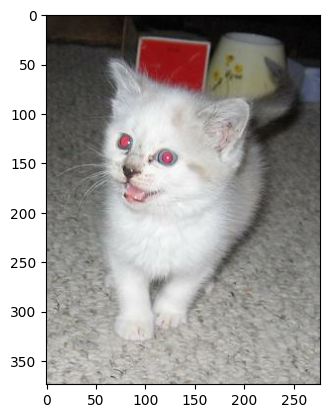

In [43]:
for x in train_data.take(1):
  plt.imshow(x['image'])
  plt.show()

In [44]:
def bicubic_interpolate(image,shape):
  img_resized=cv2.resize(image,shape, interpolation=cv2.INTER_CUBIC)
  return img_resized

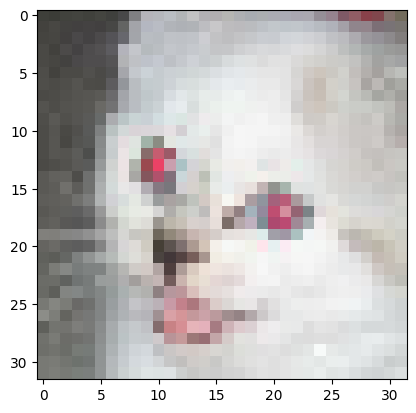

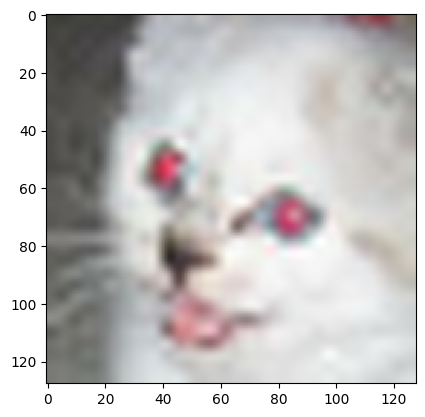

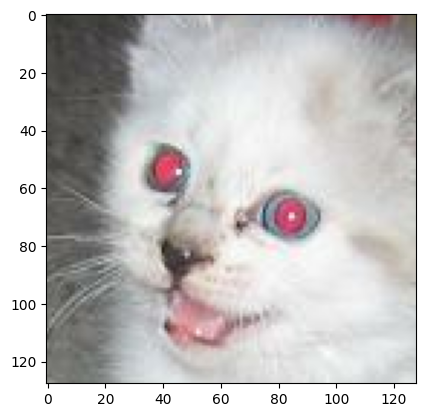

In [45]:
train_dataset_mapped = train_data.map(build_data,num_parallel_calls=tf.data.AUTOTUNE)
for x in train_dataset_mapped.take(1):
  plt.imshow(x[0].numpy())
  plt.show()

  plt.imshow(bicubic_interpolate(x[0].numpy(),(128,128)))
  plt.show()
  plt.imshow(x[1].numpy())
  plt.show()

In [62]:
def residual_block_gen(ch=64,k_s=3,st=1):
  model=tf.keras.Sequential([
    tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
  ])
  return model

def Upsample_block(x, ch=256, k_s=3, st=1):
    x = tf.keras.layers.Conv2D(ch,k_s, strides=(st,st), padding='same')(x)
    x = tf.nn.depth_to_space(x, 2) # Subpixel pixelshuffler
    x = tf.keras.layers.LeakyReLU()(x)
    return x

input_lr=tf.keras.layers.Input(shape=(None,None,3))
input_conv=tf.keras.layers.Conv2D(64,9,padding='same')(input_lr)
input_conv=tf.keras.layers.LeakyReLU()(input_conv)

SRRes=input_conv
for x in range(5):
  res_output=residual_block_gen()(SRRes)
  SRRes=tf.keras.layers.Add()([SRRes,res_output])

SRRes=tf.keras.layers.Conv2D(64,9,padding='same')(SRRes)
SRRes=tf.keras.layers.BatchNormalization()(SRRes)

SRRes=tf.keras.layers.Add()([SRRes,input_conv])

SRRes=Upsample_block(SRRes)
SRRes=Upsample_block(SRRes)

output_sr=tf.keras.layers.Conv2D(3,9,activation='tanh',padding='same')(SRRes)

SRResnet=tf.keras.models.Model(input_lr,output_sr)

In [63]:
tf.keras.utils.plot_model(SRResnet,show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [64]:
def residual_block_disc(ch=64,k_s=3,st=1):
  model=tf.keras.Sequential([
    tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
  ])
  return model

input_lr=tf.keras.layers.Input(shape=(32,32,3))
input_conv=tf.keras.layers.Conv2D(64,3,padding='same')(input_lr)
input_conv=tf.keras.layers.LeakyReLU()(input_conv)

channel_nums=[64,32,32,32,256,512,512]
stride_sizes=[2,1,2,1,2,1,2]

disc=input_conv
for x in range(7):
  disc=residual_block_disc(ch=channel_nums[x],st=stride_sizes[x])(disc)
  
disc=tf.keras.layers.Flatten()(disc)

disc=tf.keras.layers.Dense(1024)(disc)
disc=tf.keras.layers.LeakyReLU()(disc)

disc_output=tf.keras.layers.Dense(1,activation='sigmoid')(disc)

discriminator=tf.keras.models.Model(input_lr,disc_output)

In [65]:
tf.keras.utils.plot_model(discriminator,show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [66]:
def PSNR(y_true,y_pred):
  mse=tf.reduce_mean( (y_true - y_pred) ** 2 )
  return 20 * log10(1 / (mse ** 0.5))

def log10(x):
  numerator = tf.math.log(x)
  denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
  return numerator / denominator

def pixel_MSE(y_true,y_pred):
  return tf.reduce_mean( (y_true - y_pred) ** 2 )

In [67]:
VGG19=tf.keras.applications.VGG19(weights='imagenet',include_top=False,input_shape=(32,32,3))
VGG19.layers

In [68]:
GG19=tf.keras.applications.VGG19(weights='imagenet',include_top=False,input_shape=(32,32,3))

VGG_i,VGG_j=2,2
def VGG_loss(y_hr,y_sr,i_m=2,j_m=2):
  i,j=0,0
  accumulated_loss=0.0
  for l in VGG19.layers:
    cl_name=l.__class__.__name__
    if cl_name=='Conv2D':
      j+=1
    if cl_name=='MaxPooling2D':
      i+=1
      j=0
    if i==i_m and j==j_m:
      break
    
    y_hr=l(y_hr)
    y_sr=l(y_sr)
    if cl_name=='Conv2D':
      accumulated_loss+=tf.reduce_mean((y_hr-y_sr)**2) * 0.006

  return accumulated_loss
def VGG_loss_intuitive(y_true,y_pred):
  accumulated_loss=0.0
  for l in VGG19.layers:
    y_true=l(y_true)
    y_pred=l(y_pred)
    accumulated_loss+=tf.reduce_mean((y_true-y_pred)**2) * 0.006
  return accumulated_loss

In [70]:
generator_optimizer=tf.keras.optimizers.SGD(0.0001)
discriminator_optimizer=tf.keras.optimizers.SGD(0.0001)

adv_ratio=0.001
evaluate=['PSNR']
# MSE
loss_func,adv_learning = pixel_MSE,False
# VGG2.2
loss_func,adv_learning = lambda y_hr,y_sr:VGG_loss(y_hr,y_sr,i_m=2,j_m=2),False
# VGG 5.4
loss_func,adv_learning = lambda y_hr,y_sr:VGG_loss(y_hr,y_sr,i_m=5,j_m=4),False
# SRGAN-MSE
loss_func,adv_learning = pixel_MSE,True
# SRGAN-VGG 2.2
loss_func,adv_learning = lambda y_hr,y_sr:VGG_loss(y_hr,y_sr,i_m=2,j_m=2),True
# SRGAN-VGG 5.4
loss_func,adv_learning = lambda y_hr,y_sr:VGG_loss(y_hr,y_sr,i_m=5,j_m=4),True

#Real loss
loss_func,adv_learning = lambda y_hr,y_sr:VGG_loss(y_hr,y_sr,i_m=5,j_m=4),True

In [71]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

@tf.function()
def train_step(data,loss_func=pixel_MSE,adv_learning=True,evaluate=['PSNR'],adv_ratio=0.001):
  logs={}
  gen_loss,disc_loss=0,0

  low_resolution,high_resolution=data
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    super_resolution = SRResnet(low_resolution, training=True)
    gen_loss=loss_func(high_resolution,super_resolution)

    logs['reconstruction']=gen_loss

    if adv_learning:
      real_output = discriminator(high_resolution, training=True)
      fake_output = discriminator(super_resolution, training=True)
      
      adv_loss_g = generator_loss(fake_output) * adv_ratio
      gen_loss += adv_loss_g

      disc_loss = discriminator_loss(real_output, fake_output)
      
      logs['adv_g']=adv_loss_g
      logs['adv_d']=disc_loss

  gradients_of_generator = gen_tape.gradient(gen_loss, SRResnet.trainable_variables)
  generator_optimizer.apply_gradients(zip(gradients_of_generator, SRResnet.trainable_variables))

  if adv_learning:
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  for x in evaluate:
    if x=='PSNR':
      logs[x]=PSNR(high_resolution,super_resolution)

  return logs

In [73]:
for x in range(2):
  train_dataset_mapped = train_data.map(build_data,num_parallel_calls=tf.data.AUTOTUNE).batch(64)
  val_dataset_mapped = test_data.map(build_data,num_parallel_calls=tf.data.AUTOTUNE).batch(64)
  
  for image_batch in tqdm.tqdm(train_dataset_mapped, position=0, leave=True):
    logs=train_step(image_batch,loss_func,adv_learning,evaluate,adv_ratio)
    for k in logs.keys():
      print(k,':',logs[k],end='  ')
    print()

  0%|          | 0/355 [00:00<?, ?it/s]


InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} assertion failed: [Need value.shape >= size, got ] [108 108 3] [128 128 3]
	 [[{{function_node __inference_build_data_5910}}{{node random_crop/Assert/Assert}}]] [Op:IteratorGetNext] name: 

In [ ]:
SRResnet.save('SRResNet-generator.h5')
discriminator.save('SRResNet-discriminator.h5')